# EEG analysis of the Focus Protocol with Deep Learning
In this notebook, I am going to analyze EEG signals collected during afternoon work sessions for days where I perfomed the Focus Protocol right before the session (Day_X_Focus_Protocol_afternoon_work_session_xyz.csv) and on days where no protocol was performed (Day_X_No_Protocol_afternoon_work_session_xyz.csv)

My hypothesis is that we will see differences between these two types of sessions, specifically on the alpha band, since this is the frequency band most robust to noise in the EEG. 

I collected my own EEG signals using the MW75 Neuro and its  Research Kit.

In this notebook I will cover:
- Loading raw EEG data
- Apliying filters
- Removing outliers
- Extracting features (in particual alpha power)
- Use a convolutional neural network to identify if there are differences between the EEG datasets

In [1]:
# Re-loading functions
%load_ext autoreload
%autoreload 2

In [101]:
# Loading libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft
from glob import glob
from collections import defaultdict


In [3]:
# Retrieving relevant filenames
filenames = glob("../data/*.csv")
focus_protocol = "Focus_Protocol"
no_protocol = "No_Protocol"
focus_protocol_filenames = []
no_protocol_filenames = []
for filename in filenames:
    if focus_protocol in filename:
        focus_protocol_filenames.append(filename)
    elif no_protocol in filename:
        no_protocol_filenames.append(filename)


In [4]:
# Loading sample datasets
sample_file_id = 0
sample_data_after_protocol = pd.read_csv(focus_protocol_filenames[sample_file_id])
sample_data_no_protocol = pd.read_csv(no_protocol_filenames[sample_file_id])
sample_data_after_protocol

,Timestamp,EventId,Counter,Ref,DRL,Ch1RawEEG,Ch2RawEEG,Ch3RawEEG,Ch4RawEEG,Ch5RawEEG,Ch6RawEEG,Ch7RawEEG,Ch8RawEEG,Ch9RawEEG,Ch10RawEEG,Ch11RawEEG,Ch12RawEEG,FeatureStatus,Checksum
0,2025-08-04T13:22:23.756Z,239,172,1727,1723,12566.10,2971.62,-5106.38,-12366.8,-12753.9,1270.78,-21542.80,-8025.79,-46581.4,-1115.45,-12240.6,-17827.50,16,7367
1,2025-08-04T13:22:23.756Z,239,186,1719,1735,12595.80,2986.64,-4760.96,-12340.4,-12703.8,1285.16,-22516.00,-8094.69,-47956.6,-1125.72,-12205.3,-19796.20,16,7659
2,2025-08-04T13:22:23.756Z,239,197,1723,1725,12561.20,2966.87,-4650.60,-12359.3,-12766.6,1283.08,-21937.10,-8082.75,-47085.6,-1104.39,-12218.7,-18716.00,16,7543
3,2025-08-04T13:22:23.757Z,239,209,1721,1723,12589.60,2979.39,-4358.84,-12322.5,-12681.4,1277.79,-22228.40,-8093.45,-47599.7,-1125.20,-12188.7,-19530.40,16,7892
4,2025-08-04T13:22:23.757Z,239,210,1719,1725,12601.60,2978.87,-4294.30,-12327.5,-12686.0,1282.68,-22584.60,-8097.39,-47988.1,-1129.20,-12189.9,-20138.60,16,7724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288979,2025-08-04T15:02:08.992Z,239,150,1771,1771,-9469.57,-6142.20,-20425.10,-11606.7,-17963.5,-5890.98,-4402.64,-8217.76,-29060.5,-6637.64,-13563.5,-4307.34,16,8137
2288980,2025-08-04T15:02:08.992Z,239,151,1771,1773,-9477.53,-6147.73,-20339.40,-11604.1,-17963.1,-5894.79,-4394.82,-8217.36,-28916.4,-6640.95,-13565.5,-4318.64,16,7580
2288981,2025-08-04T15:02:08.992Z,239,152,1765,1771,-9477.12,-6148.95,-20230.70,-11602.1,-17963.9,-5894.15,-4491.14,-8223.13,-28815.1,-6641.69,-13568.0,-4364.68,16,8205
2288982,2025-08-04T15:02:08.992Z,239,153,1769,1778,-9474.07,-6145.73,-20134.10,-11599.4,-17962.2,-5893.12,-4614.86,-8223.80,-28751.0,-6644.50,-13567.0,-4410.10,16,7357


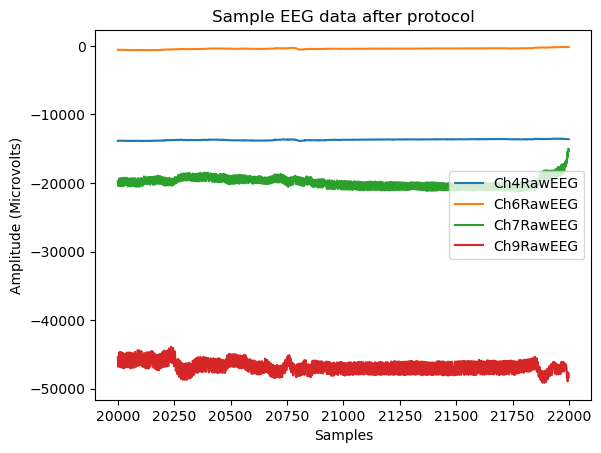

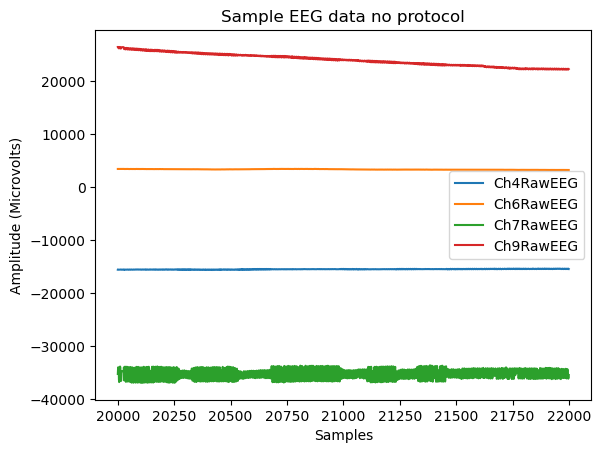

In [5]:
# Plotting sample EEG data
df_dict = {'Sample EEG data after protocol' : sample_data_after_protocol, 
           'Sample EEG data no protocol': sample_data_no_protocol}
channels_of_interest = ['Ch4RawEEG', 'Ch6RawEEG', 'Ch7RawEEG', 'Ch9RawEEG']
samples_of_interest = range(20000,22000)

for title in df_dict:
    df_dict[title][channels_of_interest].iloc[samples_of_interest].plot()
    plt.xlabel('Samples')
    plt.ylabel('Amplitude (Microvolts)')
    plt.title(title)

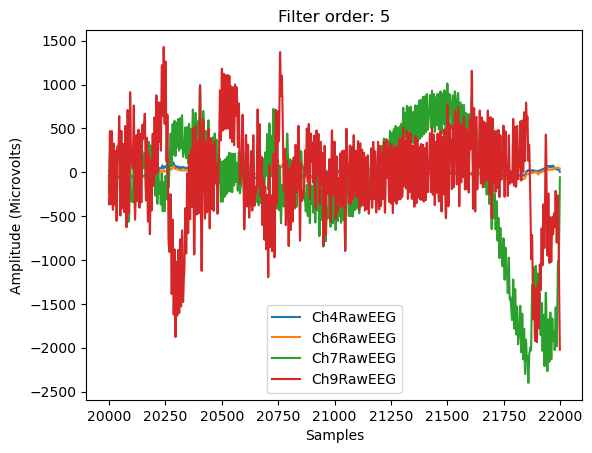

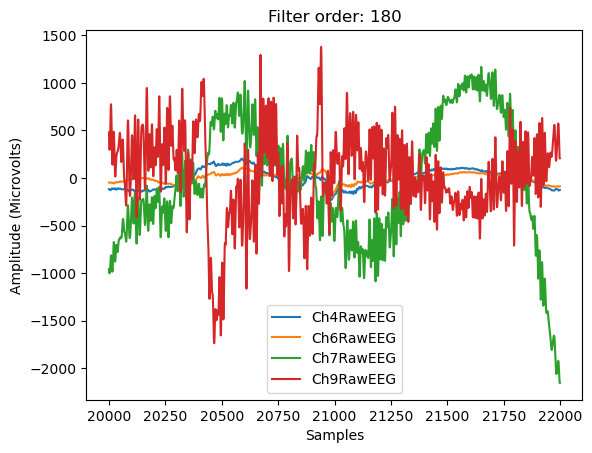

In [ ]:
# Comparing filters of different orders

filter_order = 5
strong_filter_order = 8
sampling_rate = 500
lowcut = 50
highcut = 0.5
axis_for_df = 0 
# Scipy uses by default axis -1, which in our dfs, correspond to the number of channels
# Instead we would like to filter along axis 0, which corresponds to the samples

def butter_lowpass(cutoff, fs, order=filter_order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = signal.butter(order, normal_cutoff, btype='low', analog=False, output='sos')
    return sos
def butter_lowpass_filter(data, cutoff, fs, order=filter_order):
    sos = butter_lowpass(cutoff, fs, order=order)
    y = signal.sosfilt(sos, data, axis=axis_for_df)
    return y
def butter_highpass(cutoff, fs, order=filter_order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = signal.butter(order, normal_cutoff, btype='high', analog=False, output='sos')
    return sos
def butter_highpass_filter(data, cutoff, fs, order=filter_order):
    sos = butter_highpass(cutoff, fs, order=order)
    y = signal.sosfiltfilt(sos, data, axis=axis_for_df)
    return y

# Let's check multiple filter orders for one condition
condition = list(df_dict.keys())[0]
filtered_df_dict = dict()
orders_to_try = [5, 180]
for current_filter_order in orders_to_try:
    high_pass_filtered_array = butter_highpass_filter(df_dict[condition][channels_of_interest].values, highcut, sampling_rate, order=current_filter_order)
    band_pass_filtered_array = butter_lowpass_filter(high_pass_filtered_array, lowcut, sampling_rate, order=current_filter_order)

    filtered_df_dict[current_filter_order] = pd.DataFrame(band_pass_filtered_array, columns=channels_of_interest)

    filtered_df_dict[current_filter_order][channels_of_interest].iloc[samples_of_interest].plot()
    plt.xlabel('Samples')
    plt.ylabel('Amplitude (Microvolts)')
    plt.title(f'Filter order: {current_filter_order}')


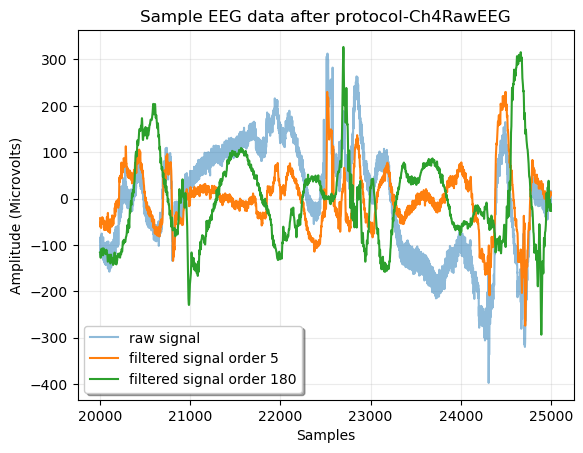

In [47]:
# Let's check for lag and distortions
x = df_dict[condition][channels_of_interest[0]].iloc[20000:25000]
baseline_correction = np.mean(x)
x_bc = x - baseline_correction
y = filtered_df_dict[orders_to_try[0]][channels_of_interest[0]].iloc[20000:25000]
y2 = filtered_df_dict[orders_to_try[1]][channels_of_interest[0]].iloc[20000:25000]
plt.plot(x_bc, alpha=0.5, label='raw signal')
plt.plot(y, label=f'filtered signal order {orders_to_try[0]}')
plt.plot(y2, label=f'filtered signal order {orders_to_try[1]}')
plt.legend(framealpha=1, shadow=True)
plt.grid(alpha=0.25)
plt.xlabel('Samples')
plt.ylabel('Amplitude (Microvolts)')
plt.title(f'{condition}-{channels_of_interest[0]}')
plt.show()

A very high filter order of 180 is significantly delayed and it starts introducing distortions to the data

Getting EEG channel names

In [48]:
eeg_columns = df_dict[condition].columns[df_dict[condition].columns.str.contains('EEG')]

Applying filter of order 5

In [ ]:
filtered_df_dict = dict()
for condition in df_dict:
    high_pass_filtered_array = butter_highpass_filter(df_dict[condition][eeg_columns].values, highcut, sampling_rate, order=filter_order)
    band_pass_filtered_array = butter_lowpass_filter(high_pass_filtered_array, lowcut, sampling_rate, order=filter_order)
    filtered_df_dict[condition] = pd.DataFrame(band_pass_filtered_array, columns=eeg_columns)


In [50]:
filtered_df_dict['Sample EEG data after protocol']

,Ch1RawEEG,Ch2RawEEG,Ch3RawEEG,Ch4RawEEG,Ch5RawEEG,Ch6RawEEG,Ch7RawEEG,Ch8RawEEG,Ch9RawEEG,Ch10RawEEG,Ch11RawEEG,Ch12RawEEG
0,0.011984,0.054968,-1.723845,0.046009,0.025138,0.035340,-0.078773,-0.112520,-0.021517,0.037099,0.053325,0.107188
1,0.145446,0.513136,-15.027195,0.446783,0.289830,0.335630,-1.954087,-1.098509,-1.952331,0.319834,0.524059,-1.559223
2,0.761594,2.290886,-62.918866,2.069135,1.473555,1.537524,-13.513587,-5.157086,-15.504896,1.352512,2.465173,-17.070838
3,2.429344,6.616357,-170.864829,6.212338,4.651926,4.578308,-50.883868,-15.716446,-61.388908,3.793229,7.526122,-74.845298
4,5.564711,14.144936,-342.879098,13.900071,10.757256,10.091278,-130.531045,-35.471154,-161.477089,8.001266,17.090499,-208.813311
...,...,...,...,...,...,...,...,...,...,...,...,...
2288979,-0.235615,-1.101889,-113.386272,-0.136296,-21.036602,-2.741533,268.272160,13.435950,-43.613576,-1.518499,-2.159111,61.341661
2288980,0.258815,-0.114153,-75.420838,0.746869,-20.123037,-2.498507,231.190098,9.908787,-9.056830,-3.051842,-3.548499,44.401055
2288981,1.186431,0.987474,-68.370863,0.527103,-19.123338,-1.857244,201.004796,6.223585,-16.254536,-4.249841,-4.123859,33.002181
2288982,2.051920,1.743770,-96.335383,-0.807617,-18.299892,-1.111610,196.591928,3.800026,-56.251884,-4.672720,-3.982652,34.105593


## Removing outliers - Bad epochs

In [51]:
# Amount of data before removing outliers
condition_to_check = list(filtered_df_dict.keys())[0]
datapoints_orig = len(filtered_df_dict[condition_to_check])

In [52]:
def remove_outliers(df, threshold=25):
    mask = ((df >= -threshold) & (df <= threshold)).all(axis=1)
    return df[mask]

thresholds_to_test = [25,50,100,150, 200, 500, 1000]

for threshold in thresholds_to_test:
    datapoints_without_outliers = len(remove_outliers(filtered_df_dict[condition_to_check], threshold=threshold))

    print(f'The percentage of datapoints kept after removing outliers above {threshold} is:')
    print(f'{np.round( datapoints_without_outliers/datapoints_orig, 2)}%')

The percentage of datapoints kept after removing outliers above 25 is:
0.0%
The percentage of datapoints kept after removing outliers above 50 is:
0.03%
The percentage of datapoints kept after removing outliers above 100 is:
0.11%
The percentage of datapoints kept after removing outliers above 150 is:
0.21%
The percentage of datapoints kept after removing outliers above 200 is:
0.0%
The percentage of datapoints kept after removing outliers above 500 is:
0.72%
The percentage of datapoints kept after removing outliers above 1000 is:
0.87%


Let's use a threshold of 200

In [54]:
chosen_threshold = 200
no_outliers_data = dict()
for condition in df_dict:
    no_outliers_data[condition] = remove_outliers(filtered_df_dict[condition], threshold=chosen_threshold)

In [55]:
# --- Plotting function ---
def plot_filtered_data(df, title):
    plt.figure(figsize=(12, 6))
    for ch in df.columns:
        plt.plot(df[ch].reset_index(drop=True), label=ch)
    plt.title(title)
    plt.xlabel("Sample")
    plt.ylabel("Amplitude (Band-Passed and outliers removed)")
    # plt.ylim(-1*chosen_threshold, chosen_threshold)  # Force y-axis limit to confirm no overflow
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


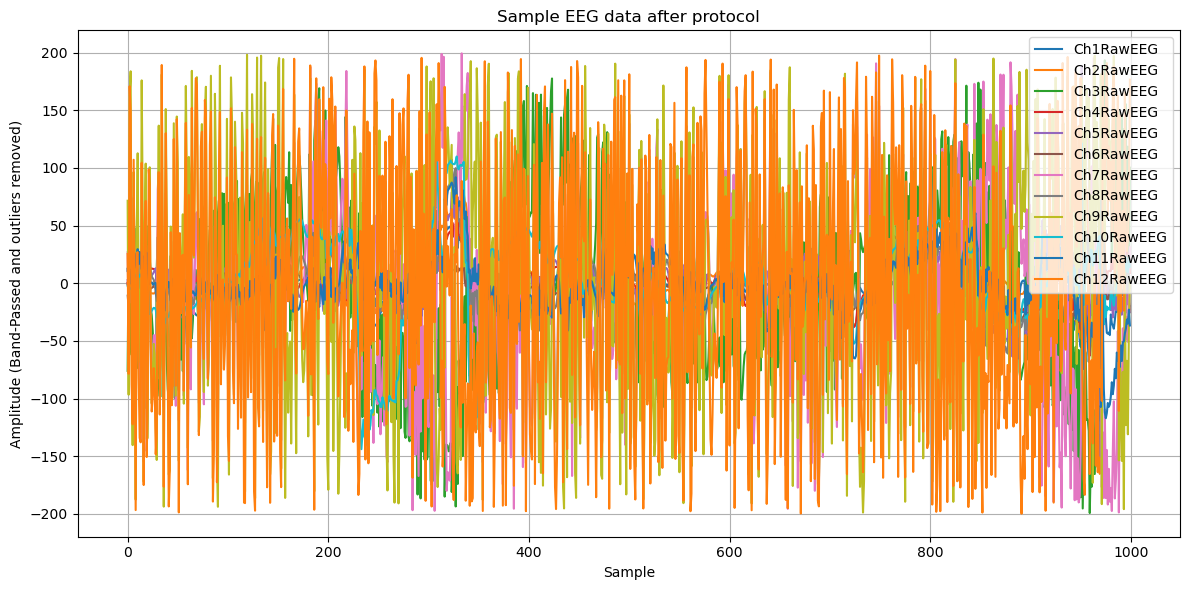

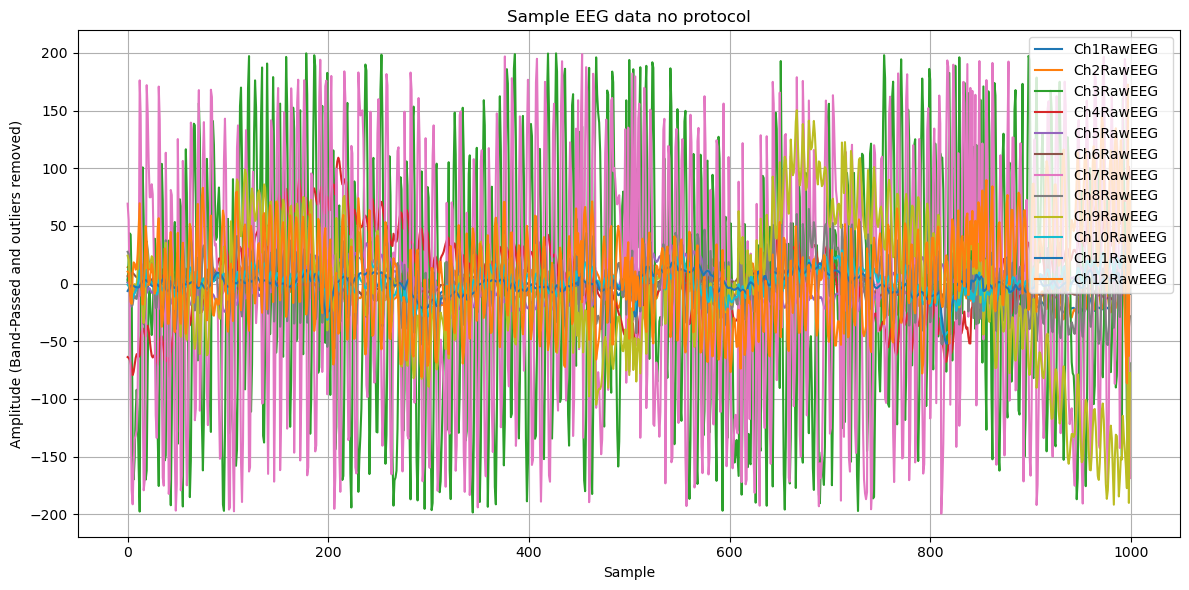

In [56]:
sample_datapoints=range(1000,2000)
for condition in no_outliers_data:
    plot_filtered_data(no_outliers_data[condition].iloc[sample_datapoints], f'{condition}')

Here we see there are some good channels behind bad channels. We need to remove bad channels first, otherwise complete rows of channels will be removed during the outlier extraction

## Removing bad channels

In [72]:
# Using Voltage peak to peak (Vpp) and sliding windows
window_size_seconds = 2
window_size_samples = sampling_rate*window_size_seconds
num_windows = int(len(filtered_df_dict[condition_to_check])/window_size_samples)
vpps = defaultdict(list)
for channel in eeg_columns:
    eeg_values_per_ch = filtered_df_dict[condition_to_check][channel].values
    for i in range(1,num_windows):
        window_data = eeg_values_per_ch[i*window_size_samples:(i+1)*window_size_samples]
        vpps[channel].append(np.max(window_data) - np.min(window_data))


Text(0.5, 1.0, 'Voltage peak to peak for each window and channel')

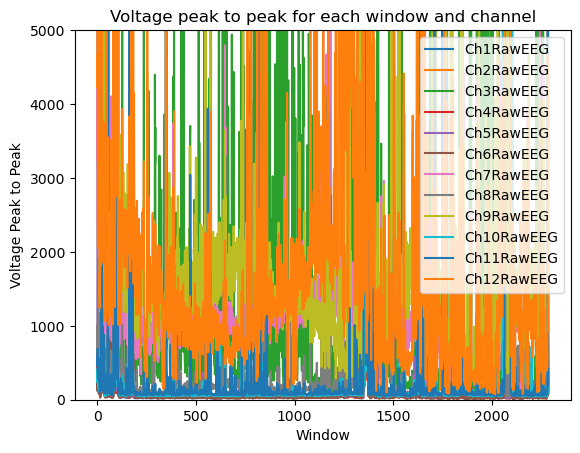

In [80]:
vpps_df = pd.DataFrame.from_dict(vpps)
vpps_df.plot()
plt.ylim((0,5000))
plt.xlabel('Window')
plt.ylabel('Voltage Peak to Peak')
plt.title('Voltage peak to peak for each window and channel')

In [86]:
# Let's search percentage of windows above threshold for each channel:
channel = eeg_columns[0]
threshold_vpp = 500
threshold_proportion_windows = 0.5
good_eeg_channels = []
bad_eeg_channels = []
for channel in eeg_columns:
    is_window_above_threshold = vpps_df[channel] > threshold_vpp
    percent_over_threshold = sum(is_window_above_threshold)/len(is_window_above_threshold)
    print(f'For channel {channel}, {np.round(percent_over_threshold, 2)} of windows are over threhold {threshold_vpp}')
    if percent_over_threshold > threshold_proportion_windows:
        bad_eeg_channels.append(channel)
    elif percent_over_threshold <= threshold_proportion_windows:
        good_eeg_channels.append(channel) 

For channel Ch1RawEEG, 0.02 of windows are over threhold 500
For channel Ch2RawEEG, 0.02 of windows are over threhold 500
For channel Ch3RawEEG, 0.51 of windows are over threhold 500
For channel Ch4RawEEG, 0.02 of windows are over threhold 500
For channel Ch5RawEEG, 0.04 of windows are over threhold 500
For channel Ch6RawEEG, 0.05 of windows are over threhold 500
For channel Ch7RawEEG, 0.86 of windows are over threhold 500
For channel Ch8RawEEG, 0.1 of windows are over threhold 500
For channel Ch9RawEEG, 0.93 of windows are over threhold 500
For channel Ch10RawEEG, 0.05 of windows are over threhold 500
For channel Ch11RawEEG, 0.08 of windows are over threhold 500
For channel Ch12RawEEG, 0.86 of windows are over threhold 500


In [87]:
bad_eeg_channels

['Ch3RawEEG', 'Ch7RawEEG', 'Ch9RawEEG', 'Ch12RawEEG']

## Removing bad epochs again
But only considering good channels this time

In [94]:
print(f'Percentage of datapoints kept after removing outliers above  threshold:')

print('threshold\t% before removing bad channels\t% after removing bad channels')
for threshold in thresholds_to_test:
    datapoints_without_outliers = len(remove_outliers(filtered_df_dict[condition_to_check][good_eeg_channels], threshold=threshold))
    datapoints_without_outliers_all_ch = len(remove_outliers(filtered_df_dict[condition_to_check], threshold=threshold))
    print(f'{threshold}\t{int(datapoints_without_outliers_all_ch/datapoints_orig*100)}%\t{int(datapoints_without_outliers/datapoints_orig*100)}%')



Percentage of datapoints kept after removing outliers above  threshold:
threshold	% before removing bad channels	% after removing bad channels
25	0%	48%
50	2%	74%
100	11%	86%
150	20%	90%
200	29%	91%
500	72%	95%
1000	87%	96%


In [96]:
# Now I feel more comfortable of choosing a threshold of 50 even!
chosen_threshold = 50
no_outliers_data = dict()
for condition in df_dict:
    no_outliers_data[condition] = remove_outliers(filtered_df_dict[condition][good_eeg_channels], threshold=chosen_threshold)

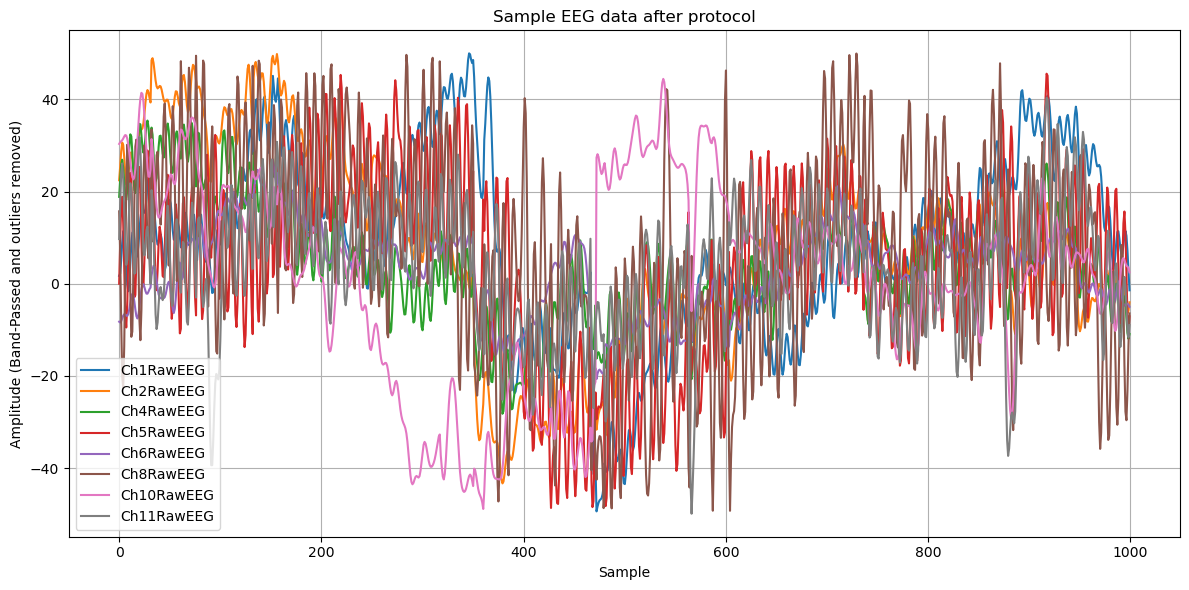

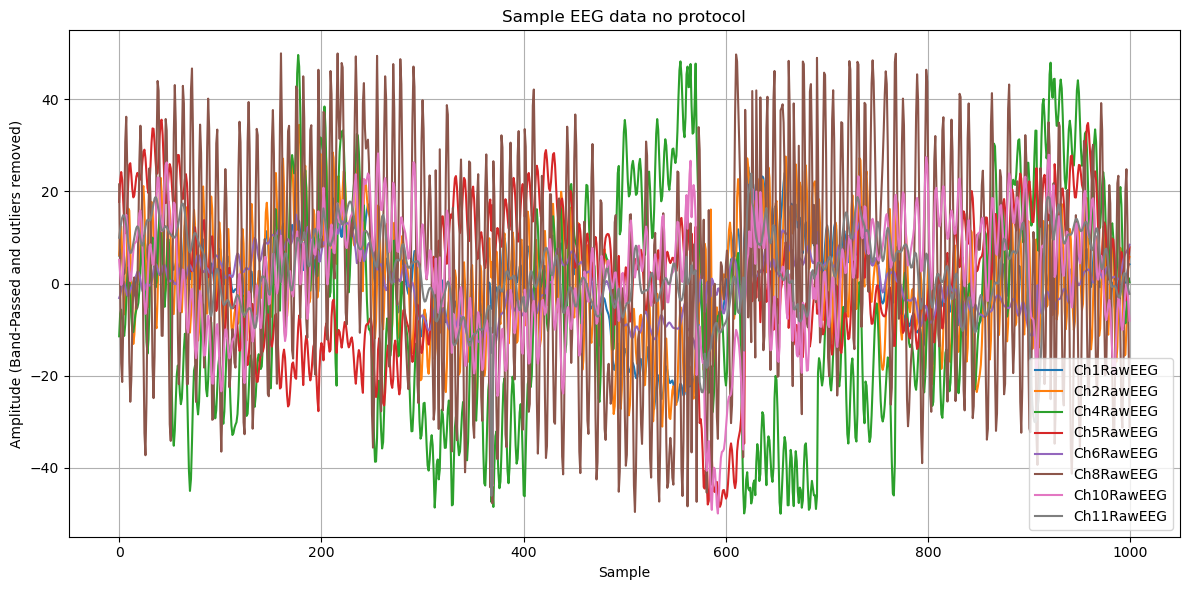

In [97]:
sample_datapoints=range(1000,2000)
for condition in no_outliers_data:
    plot_filtered_data(no_outliers_data[condition].iloc[sample_datapoints], f'{condition}')

There are still some extaneous oscillations. What is their frequency? 60 Hz

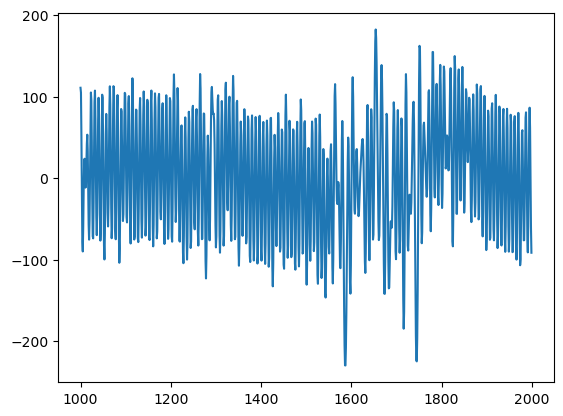

In [102]:
filtered_df_dict[condition]['Ch8RawEEG'].iloc[sample_datapoints].plot()
y = filtered_df_dict[condition]['Ch8RawEEG'].iloc[sample_datapoints].values

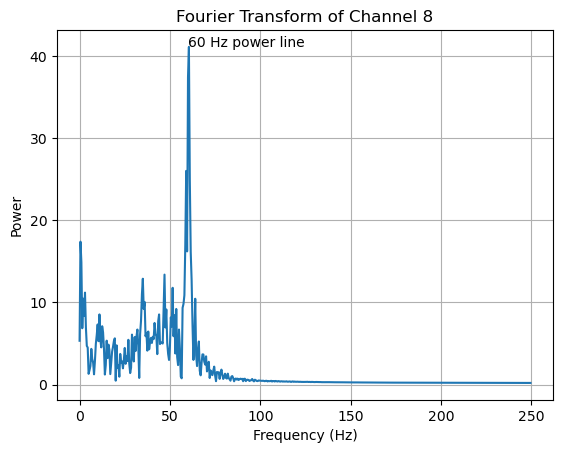

In [105]:
# Number of sample points
N = len(y)
# sample spacing
T = 1.0 / sampling_rate
x = np.linspace(0.0, N*T, N, endpoint=False)
yf = fft.fft(y)
xf = fft.fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.title('Fourier Transform of Channel 8')
plt.ylabel("Power")
plt.xlabel("Frequency (Hz)")
plt.annotate("60 Hz power line", [60, max(2.0/N * np.abs(yf[0:N//2]))])
plt.show()

Okay, the extraneous oscillation is just the 60 Hz power line. Our filter is low order (5), so not strong enough to keep it out. 

## Recap: Removing outliers:
1. Exclude bad channels (these might need to be consistent accross all datasets)
2. Exclude bad epochs

## Extrancting Alpha Power

In [ ]:
# Parameters
window_size = sampling_rate  # 1-second windows
alpha_band = (8, 12)

# Function to compute alpha power for a signal chunk
def compute_alpha_power(signal_chunk, fs, fmin=alpha_band[0], fmax=alpha_band[1]):
    freqs, psd = signal.welch(signal_chunk.values, fs=fs, nperseg=len(signal_chunk))
    alpha_idx = np.logical_and(freqs >= fmin, freqs <= fmax)
    alpha_power = np.trapezoid(psd[alpha_idx], freqs[alpha_idx])
    return alpha_power

# Function to compute alpha power time series
def compute_alpha_time_series(df, fs):
    alpha_dict = {ch: [] for ch in df}
    num_chunks = len(df) // window_size

    for i in range(num_chunks):
        start = i * window_size
        end = start + window_size
        for ch in df.columns:
            chunk = df[ch].iloc[start:end]
            if len(chunk) == window_size:
                alpha_power = compute_alpha_power(chunk, fs)
                alpha_dict[ch].append(alpha_power)
    return pd.DataFrame(alpha_dict)

# Compute for both morning and evening
evening_alpha_df = compute_alpha_time_series(data_morning_band_pass_filtered, fs)
morning_alpha_df = compute_alpha_time_series(data_evening_band_pass_filtered, fs)

# Save results to CSV
# evening_alpha_df.to_csv("evening_alpha_power_timeseries.csv", index=False)
# morning_alpha_df.to_csv("morning_alpha_power_timeseries.csv", index=False)

# Plot example for ch1
plt.figure(figsize=(12, 6))
plt.plot(morning_alpha_df['ch2'], label='Morning - ch1', alpha=0.7)
plt.plot(evening_alpha_df['ch2'], label='Evening - ch1', alpha=0.7)
plt.title("Alpha Power Over Time - ch1")
plt.xlabel("Time Window (1 sec)")
plt.ylabel("Alpha Power (8–12 Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot example for ch2
plt.figure(figsize=(12, 6))
plt.plot(morning_alpha_df['ch2'], label='Morning - ch2', alpha=0.7)
plt.plot(evening_alpha_df['ch2'], label='Evening - ch2', alpha=0.7)
plt.title("Alpha Power Over Time - ch2")
plt.xlabel("Time Window (1 sec)")
plt.ylabel("Alpha Power (8–12 Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot example for ch3
plt.figure(figsize=(12, 6))
plt.plot(morning_alpha_df['ch3'], label='Morning - ch3', alpha=0.7)
plt.plot(evening_alpha_df['ch3'], label='Evening - ch3', alpha=0.7)
plt.title("Alpha Power Over Time - ch3")
plt.xlabel("Time Window (1 sec)")
plt.ylabel("Alpha Power (8–12 Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot example for ch4
plt.figure(figsize=(12, 6))
plt.plot(morning_alpha_df['ch4'], label='Morning - ch4', alpha=0.7)
plt.plot(evening_alpha_df['ch4'], label='Evening - ch4', alpha=0.7)
plt.title("Alpha Power Over Time - ch4")
plt.xlabel("Time Window (1 sec)")
plt.ylabel("Alpha Power (8–12 Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
